<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Detect and Measure Sources in a Custom Coadded Image</b> <br>
Contact author: Melissa Graham <br>
Last verified to run: 2023-04-12 <br>
LSST Science Pipelines version: <b>Weekly 2022_40</b> <br>
Container Size: large <br>
Targeted learning level: advanced <br>

___

**WARNING:
This notebook will only run with LSST Science Pipelines version Weekly 2022_40.**

To find out which version of the LSST Science Pipelines you are using, look in the footer bar or execute the cell below.

In [1]:
! echo $IMAGE_DESCRIPTION

Weekly 2022_40


If you are using `w_2022_40`, you may proceed with executing the tutorial.

If you are **not** using `w_2022_40` you **must** log out and start a new server:
 1. At top left in the menu bar choose File then Save All and Exit.
 2. Re-enter the Notebook Aspect.
 3. At <a href="https://dp0-2.lsst.io/data-access-analysis-tools/nb-intro.html#how-to-log-in-navigate-and-log-out-of-jupyterlab">the "Server Options" stage</a>, under "Select uncached image (slower start)" choose `w_2022_40`.
 4. Note that it might take a few minutes to start your server with an old image.

___

<br><br><br><br>

**Description:** Detect and measure sources in a custom "deepCoadd" image.

**Skills:** Use the butler on user-generated collections. Run source detection and measurement.

**LSST Data Products:** user-generated deepCoadd; DP0.2 deepCoadd image and Object table

**Packages:** lsst.afw, lsst.pipe, lsst.meas

**Credit:** Originally developed by Melissa Graham and Clare Saunders, this tutorial draws on the contents of the "Introduction to Source Detection" DP0.2 tutorial notebook by Douglas Tucker and Alex Drlica-Wagner.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.


> **WARNING: This tutorial uses the output of notebook 09a_Custom_Coadd.ipynb. Users must run that notebook first.**


# 1. Introduction

This tutorial notebook is a follow-up to 09a_Custom_Coadd.ipynb, and demonstrates how to run source detection and measurement on a user-generated custom `deepCoadd` image.

Recall that although that new custom `deepCoadd` is not actually deep, but a rather shallower custom coadd, it will still be called `deepCoadd` in the butler because that is the default name of results from the `assembleCoadd` task.

**This tutorial notebook may evolve in the near future.**
In tutorial notebook 09a_Custom_Coadd.ipynb, we use the Simple Pipeline Executor (SPE) to build a pipeline that runs components of the Data Release Pipeline (DRP).
In _this_ tutorial notebook, instead of building a pipeline to run the DRP components for detection, deblending, and measurement, and then writing a table with the same schema as the `Object` table, we are simply executing the standalone tasks for source detection and measurement. This is faster and simpler, but in the future this notebook will be updated to use the SPE.

## 1.1. Package imports

In [2]:
import time, getpass
import numpy as np
import pandas
import matplotlib.pyplot as plt
from astropy.wcs import WCS

import lsst.geom
from lsst.daf.butler import Butler, CollectionType
from lsst.rsp import get_tap_service, retrieve_query
import lsst.daf.base as dafBase
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage

from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

## 1.2. Define functions and parameters

Set `afwDisplay` to use a `matplotlib` backend.

In [3]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service, which is used in Section 3.3.

In [4]:
tap_service = get_tap_service()

## 1.3. Find the desired coadd in the butler

Create a temporary butler in order to identify the collection and run containing the custom `deepCoadd`.

In [5]:
my_username = getpass.getuser()
butler_repo = 'dp02'

In [6]:
tempButler = Butler(butler_repo)

Print all collections and runs associated with your username.

In [7]:
for c in sorted(tempButler.registry.queryCollections('*'+my_username+'*')):
    print(c)

u/ameisner/custom_coadd_window1_cl00
u/ameisner/custom_coadd_window1_cl00/20230502T052541Z
u/ameisner/custom_coadd_window1_cl00/20230514T103114Z
u/ameisner/custom_coadd_window1_cl00/20230514T121205Z
u/ameisner/custom_coadd_window1_cl00/20230514T212053Z
u/ameisner/custom_coadd_window1_cl00/20230603T001742Z
u/ameisner/custom_coadd_window1_cl00/20230817T123603Z
u/ameisner/custom_coadd_window1_cl00/20230826T102521Z
u/ameisner/custom_coadd_window1_cl00/20230827T122706Z
u/ameisner/custom_coadd_window1_cl00/20230827T224022Z
u/ameisner/custom_coadd_window1_cl00/20230918T050251Z
u/ameisner/custom_coadd_window1_cl00/20230918T050641Z
u/ameisner/custom_coadd_window1_cl00/20230918T052104Z
u/ameisner/custom_coadd_window1_cl00/20230918T052710Z
u/ameisner/custom_coadd_window1_cl00/20230918T054822Z
u/ameisner/custom_coadd_window1_cl00/20230927T225000Z
u/ameisner/custom_coadd_window1_cl00/20230929T114336Z
u/ameisner/custom_coadd_window1_cl00/20230929T121843Z
u/ameisner/custom_coadd_window1_cl00/20231006

Delete this temporary butler.

In [8]:
del tempButler

Create a new butler with the collection containing the custom `deepCoadd`.

> **Stop!** Make sure the name of the collection below matches the name of your own collection that you created with tutorial notebook 09a_Custom_Coadd.ipynb.

In [9]:
inputCollection = "u/"+my_username+"/custom_coadd_window1_test1"
print(inputCollection)

u/ameisner/custom_coadd_window1_test1


In [10]:
butler = Butler(butler_repo, collections=[inputCollection])

Use the `dataId` from tutorial notebook 09a_Custom_Coadd.ipynb and retrieve the custom `deepCoadd`.

In [11]:
my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
my_deepCoadd = butler.get('deepCoadd', my_dataId)

Confirm that the retrieved `deepCoadd` is the custom user-generated 6-input visits version.

In [12]:
my_deepCoadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
919515,11900,7900,16099,12099,8982709,3.4656688819793495,i_sim_1.4
924057,11900,7900,16099,12099,16098179,4.384267091685517,i_sim_1.4
924085,11900,7900,16099,12099,831332,4.446833161599578,i_sim_1.4
924086,11900,7900,16099,12099,16136708,4.550420295334223,i_sim_1.4
929477,11900,7900,16099,12099,16280498,4.051326013718346,i_sim_1.4
930353,11900,7900,16099,12099,16076133,3.7685753871220466,i_sim_1.4


# 2. Run source detection, deblending, and measurement

note: this SPE usage basically just parallels what's done in notebook 9a for generating the custom coadd

In [13]:
my_outputCollection_identifier = 'custom_coadd_window1_test1_nbdet'
my_outputCollection = 'u/' + my_username + '/'+ my_outputCollection_identifier
print(my_outputCollection)

u/ameisner/custom_coadd_window1_test1_nbdet


In [14]:
simpleButler = SimplePipelineExecutor.prep_butler(butler_repo, 
                                                  inputs=[inputCollection], 
                                                  output=my_outputCollection)

In [15]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/ameisner/custom_coadd_window1_test1_nbdet/20231106T054930Z', 'u/ameisner/custom_coadd_window1_test1'))

In [16]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml'
steps = 'detection,mergeDetections,deblend,measure'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#detection,mergeDetections,deblend,measure


In [17]:
sourceDetectionPipeline = Pipeline.from_uri(my_uri)

In [18]:
sourceDetectionPipeline.addConfigOverride('detection', 'detection.thresholdValue', 10.0)
sourceDetectionPipeline.addConfigOverride('detection', 'detection.thresholdType', "stdev")
sourceDetectionPipeline.addConfigOverride('deblend', 'multibandDeblend.maxIter', 20)
sourceDetectionPipeline.addConfigOverride('measure', 'doPropagateFlags', False)

OPTIONAL: create the quantum graph

note that this optional quantum graph making stuff prints out a warning that can be ignored

In [ ]:
#from lsst.ctrl.mpexec import pipeline2dot
#pipeline2dot(sourceDetectionPipeline, '/home/' + my_username + '/custom_coadd_qgraph.dot')

#! dot -Tpng /home/$USER/custom_coadd_qgraph.dot > /home/$USER/source_detection_qgraph.png

here's what the quantumgraph looks like

<img align="left" src = https://raw.githubusercontent.com/rubin-dp0/cst-dev/main/AMM_detritus/9b_command_line/source_detection_qgraph.png width="100%" style="padding: 10px">

In [19]:
queryString = f"tract = 4431 AND patch = 17 AND band = 'i' AND skymap = 'DC2'"

In [20]:
#this gives a warning that can be ignored

spe = SimplePipelineExecutor.from_pipeline(sourceDetectionPipeline, 
                                           where=queryString, 
                                           butler=simpleButler)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/pipe_tasks/g369a80f31c+b9be13ffc2/python/lsst/pipe/tasks/multiBand.py:261: UserWarning: MeasureMergedCoaddSourcesConnections.defaultTemplates is deprecated and no longer used. Use MeasureMergedCoaddSourcesConfig.inputCatalog.
  warnings.warn("MeasureMergedCoaddSourcesConnections.defaultTemplates is deprecated and no longer used. "
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/pex_config/g71c1dbb2b5+9a7299d786/python/lsst/pex/config/configurableField.py:79: FutureWarning: Call to deprecated class LoadIndexedReferenceObjectsConfig. (This config is no longer used; it will be removed after v25. Please use LoadReferenceObjectsConfig instead.) -- Deprecated since version v25.0.
  value = self._ConfigClass(__name=name, __at=at, __label=label, **storage)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/pex_config/g71c1dbb2b5+9a7299d786/python/lsst/pex/config/configurableField.py:359: Futur

In [21]:
quanta = spe.run()

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in true_divide
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/measure.py:35: RuntimeWarning: invalid value encountered in multiply
  denominator = (psfs * noise) * psfs
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/parameters.py:302: RuntimeWarning: invalid value encountered in true_divide
  _z = self.prox(z - gamma/step * psi * (z-self.x), gamma)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/parameters.py:302: RuntimeWarning: invalid value encountered in subtract
  _z = self.prox(z - gamma/step * psi * (z-self

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/measure.py:85: RuntimeWarning: divide by zero encountered in true_divide
  ratio = numerator / denominator
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/scarlet/gd32b658ba2+4083830bf8/lib/python/scarlet/lite/measure.py:85: RuntimeWarning: invalid value encountered in true_divide
  ratio = numerator / denominator


The above run of source detection, deblending, and measurement takes about 10-12 minutes.

# 3. Analyze sources

## 3.1. Explore the source table contents

Make the results into an astropy table for better human interaction.

First, make a copy.
Otherwise, the second cell below will fail with the error message _"Record data is not contiguous in memory."_

In [23]:
butler = Butler(butler_repo, collections=[my_outputCollection])

In [25]:
sources = butler.get('deepCoadd_meas', dataId=my_dataId)

In [26]:
sources = sources.copy(True)

In [27]:
my_sources = sources.asAstropy()

**Option:** print all of the column names of source measurements.

In [28]:
my_sources.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'merge_footprint_i',
 'merge_footprint_r',
 'merge_footprint_z',
 'merge_footprint_y',
 'merge_footprint_g',
 'merge_footprint_u',
 'merge_footprint_sky',
 'merge_peak_i',
 'merge_peak_r',
 'merge_peak_z',
 'merge_peak_y',
 'merge_peak_g',
 'merge_peak_u',
 'merge_peak_sky',
 'deblend_runtime',
 'deblend_iterations',
 'deblend_nChild',
 'deblend_nPeaks',
 'deblend_skipped',
 'deblend_isolatedParent',
 'deblend_isPseudo',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_sedConvergenceFailed',
 'deblend_morphConvergenceFailed',
 'deblend_blendConvergenceFailedFlag',
 'deblend_failed',
 'deblend_error',
 'deblend_peak_center_x',
 'deblend_peak_center_y',
 'deblend_peakId',
 'deblend_peak_instFlux',
 'deblend_modelType',
 'deblend_parentNPeaks',
 'deblend_parentNChild',
 'deblend_scarletFlux',
 'deblend_logL',
 'deblend_edgePixels',
 'deblend_spectrumInitFlag',
 'deblend_nComponents',
 'deblend_deblendedAsPsf',
 'd

**Option:** explore which columns are flux measurements (not flux flags!) and which have been populated with nonzero flux values.

In [29]:
for col in my_sources.colnames:
     if ((col.find('Flux') >= 0) | (col.find('flux') >= 0)) & (col.find('flag') < 0):
         tx = np.where(my_sources[col] > 0.0)[0]
         print(len(tx), col)
         del tx

2922 deblend_peak_instFlux
2923 deblend_scarletFlux
395 deblend_fluxOverlap
395 deblend_fluxOverlapFraction
5407 base_Blendedness_raw_child_instFlux
5407 base_Blendedness_raw_parent_instFlux
5408 base_Blendedness_abs_child_instFlux
5408 base_Blendedness_abs_parent_instFlux
5255 base_SdssShape_instFlux
5255 base_SdssShape_instFluxErr
0 base_SdssShape_instFlux_xx_Cov
0 base_SdssShape_instFlux_yy_Cov
2641 base_SdssShape_instFlux_xy_Cov
5517 ext_shapeHSM_HsmSourceMomentsRound_Flux
5517 slot_ShapeRound_Flux
5539 base_CircularApertureFlux_3_0_instFlux
5603 base_CircularApertureFlux_3_0_instFluxErr
5538 base_CircularApertureFlux_4_5_instFlux
5603 base_CircularApertureFlux_4_5_instFluxErr
5531 base_CircularApertureFlux_6_0_instFlux
5603 base_CircularApertureFlux_6_0_instFluxErr
5504 base_CircularApertureFlux_9_0_instFlux
5562 base_CircularApertureFlux_9_0_instFluxErr
5479 base_CircularApertureFlux_12_0_instFlux
5479 slot_ApFlux_instFlux
5479 slot_CalibFlux_instFlux
5545 base_CircularApertureFl

Convert `instFlux` to AB apparent magnitudes.

In [30]:
my_sources.add_column('i_CalibMag_AB')
my_sources['i_CalibMag_AB'] = np.zeros(len(my_sources), dtype='float')
my_deepCoadd_photoCalib = my_deepCoadd.getPhotoCalib()
for s in range(len(my_sources)):
    my_sources['i_CalibMag_AB'][s] = \
    my_deepCoadd_photoCalib.instFluxToMagnitude(my_sources['base_CircularApertureFlux_12_0_instFlux'][s])

Plot the apparent i-band magnitude distribution of detected sources.

In [35]:
my_sources = my_sources[my_sources['detect_isPrimary'] == True]


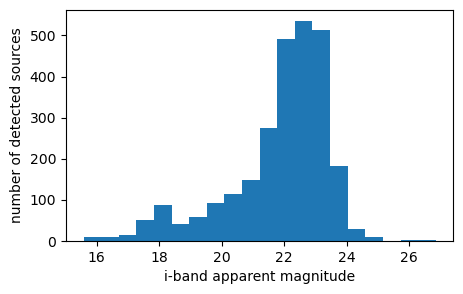

In [36]:
plt.figure(figsize=(5, 3))
plt.hist(my_sources['i_CalibMag_AB'], bins=20)
plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.show()

## 3.2. Plot detected sources on a cutout of the custom coadd

Create a 1000 by 1000 pixel cutout of the custom `deepCoadd`.

In [37]:
cutout_width = 1000
cutout_height = 1000
my_cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(my_deepCoadd.getX0(),
                                                   my_deepCoadd.getY0()),
                                 lsst.geom.Extent2I(cutout_width, cutout_height))
my_cutout = my_deepCoadd.Factory(my_deepCoadd, my_cutout_bbox)

Print the center coordinates of the cutout.

In [38]:
bbox = my_cutout.getBBox()
wcs = my_cutout.wcs
fitsMd = wcs.getFitsMetadata()
WCSfMd = WCS(fitsMd)
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
print('Cutout center (RA, Dec): ', center)

Cutout center (RA, Dec):  (55.7572944294, -32.2945077996)


Recall from tutorial notebook 09a that the 'science use case' adopted for context was that there was a (hypothetical) supernova at RA = 55.745834, Dec = -32.269167, and we were looking for evidence of a precursor outburst during Window1.

Convert those coordinates into a pixel location.

In [39]:
sn_coords = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
sn_pix = wcs.skyToPixel(sn_coords)
print(sn_pix)

(12573, 8855.8)


Display cutout with detected sources as orange circles, and the supernova location as a larger green circle.

<Figure size 640x480 with 0 Axes>

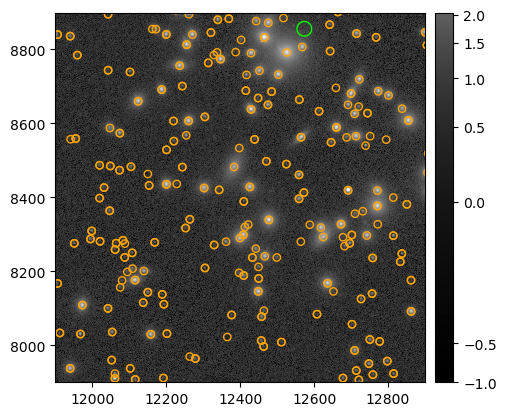

In [40]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.image)

afw_display.dot('o', sn_pix[0], sn_pix[1], size=20, ctype='green')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

Above, we can see that there is no source detected at 10-sigma (defined by `config.thresholdValue` above in Section 2.2) at the location of the (hypothetical) supernova (green circle). 

In Section 4, an exercise for the learner is to re-run source detection with a lower sigma, which would be the next analysis step for the science use-case of exploring precursor eruptions.
Recall that the DC2 simulation did not include precursor eruptions for supernovae, though -- and that there is no actual simulated supernova at the coordinates anyway. 
They are just used as an example.

In [41]:
del bbox, wcs, fitsMd, WCSfMd, center

## 3.3. Compare with Objects in the original deepCoadd image

### 3.3.1. Make a cutout of the original deepCoadd

Instantiate a temporary butler that looks only at the DP0.2 collection.

In [42]:
tempButler = Butler(butler_repo, collections='2.2i/runs/DP0.2')

Use the same `dataId` that defines the custom `deepCoadd`.
Since we are using a temporary butler that only looks at the DP0.2 data release collection, and not the user collection, this will retrieve the original `deepCoadd`, not the custom `deepCoadd`.

In [43]:
deepCoadd = tempButler.get('deepCoadd', my_dataId)

Double check that this `deepCoadd` is the result of 161 input visits.

In [44]:
deepCoadd_inputs = tempButler.get("deepCoadd.coaddInputs", my_dataId)
len(deepCoadd_inputs.visits.asAstropy())

161

In [45]:
del tempButler

Create a cutout from the original `deepCoadd`.

In [46]:
cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(deepCoadd.getX0(),
                                                deepCoadd.getY0()),
                              lsst.geom.Extent2I(cutout_width, cutout_height))
cutout = deepCoadd.Factory(deepCoadd, cutout_bbox)

**Option:** display the original `deepCoadd` cutout.

<Figure size 640x480 with 0 Axes>

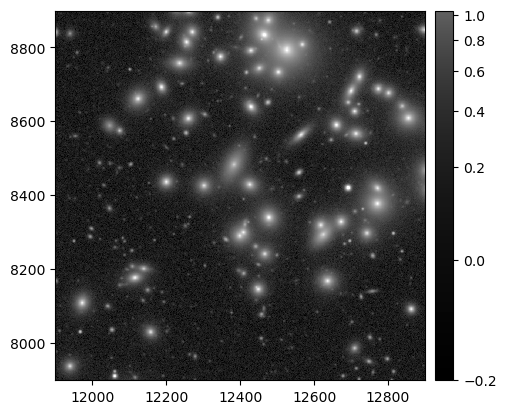

In [47]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)

### 3.3.2. Retrieve Objects via TAP

Use the TAP service to query and return the i-band calibrated fluxes for `Objects` detected with a signal-to-noise ratio > 10 (to match the custom coadd detection threshold set in Section 2.2) in the original `deepCoadd`, within the cutout area.

Recall that the cutout center coordinates are: 55.7572944294, -32.2945077996. Use these as the central coordinates for the TAP query.

In [48]:
%%time
query = "SELECT objectId, coord_ra, coord_dec, detect_isPrimary, " + \
        "scisql_nanojanskyToAbMag(i_calibFlux) AS i_calibMag, " + \
        "scisql_nanojanskyToAbMagSigma(i_calibFlux, i_calibFluxErr) AS i_calibMagErr, " + \
        "i_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.757, -32.295, 0.2)) = 1 " + \
        "AND i_calibFlux/i_calibFluxErr >= 10 " + \
        "AND detect_isPrimary = 1"
tap_results = tap_service.search(query)

CPU times: user 353 ms, sys: 11.9 ms, total: 365 ms
Wall time: 5.79 s


Store the TAP results in a pandas table.

In [49]:
tap_table = tap_results.to_table().to_pandas()

Convert `Object` sky coordinates (RA, Dec) to `deepCoadd` pixels (x,y) and store in the TAP results table.

In [50]:
wcs = cutout.wcs
temp1 = np.zeros(len(tap_table), dtype='float')
temp2 = np.zeros(len(tap_table), dtype='float')

for i in range(len(tap_table['coord_ra'].values)):
    sP = lsst.geom.SpherePoint(tap_table['coord_ra'][i]*lsst.geom.degrees, \
                               tap_table['coord_dec'][i]*lsst.geom.degrees)
    cpix = wcs.skyToPixel(sP)
    temp1[i] = float(cpix[0])
    temp2[i] = float(cpix[1])
    del sP, cpix

tap_table['cutout_x'] = temp1
tap_table['cutout_y'] = temp2

del wcs, temp1, temp2

### 3.3.3. Plot images side-by-side

Plot the new custom `deepCoadd` (left; 6 input visits) and original `deepCoadd` (right; 161 input visits) cutouts side-by-side.

Show newly detected sources in the custom `deepCoadd` (orange) and `Object` catalog sources from the original `deepCoadd` (red).

Making these side-by-side images can take a minute.

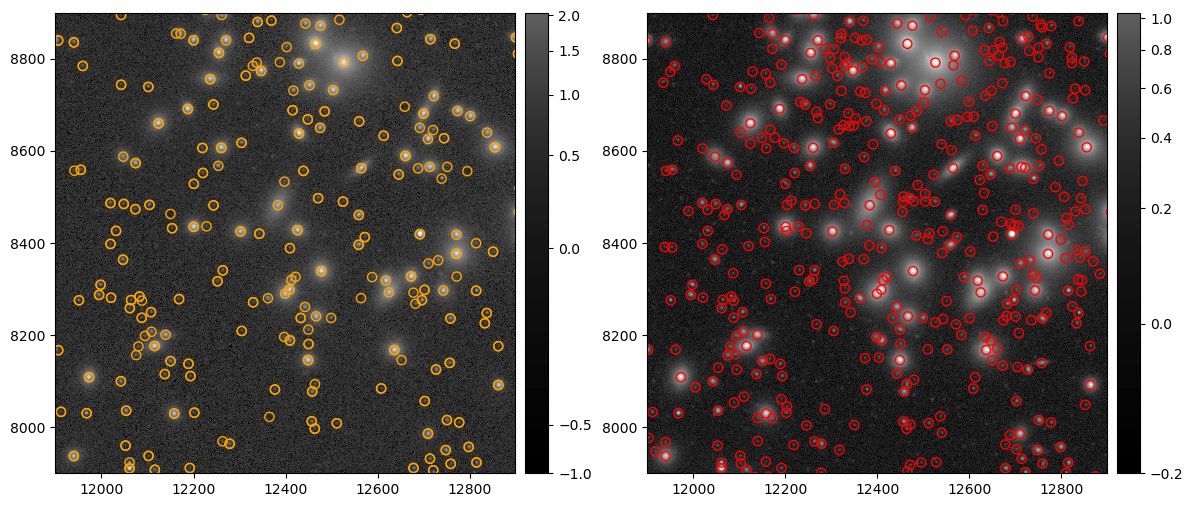

CPU times: user 20.1 s, sys: 253 ms, total: 20.3 s
Wall time: 20.1 s


In [51]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False, sharex=False)

plt.subplot(1, 2, 1)
disp1 = afwDisplay.getDisplay(frame=fig)
disp1.scale('asinh', 'zscale')
disp1.mtv(my_cutout.image)

with disp1.Buffering():
    for s in sources:
        disp1.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

plt.subplot(1, 2, 2)
disp2 = afwDisplay.getDisplay(frame=fig)
disp2.scale('asinh', 'zscale')
disp2.mtv(cutout.image)

with disp2.Buffering():
    for s in range(len(tap_table)):
        disp2.dot('o', tap_table['cutout_x'][s], tap_table['cutout_y'][s], size=10, ctype='red')

plt.show()

### 3.3.4. Compare apparent magnitudes

For sources detected in both the custom `deepCoadd` _and_ the original `deepCoadd`, plot a comparison of their apparent i-band magnitudes.

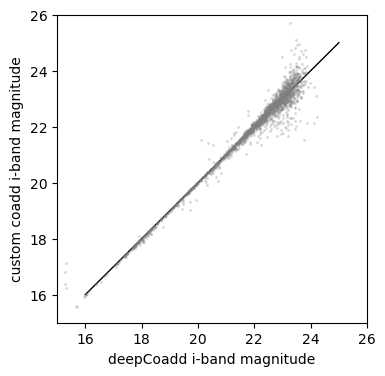

In [52]:
plt.figure(figsize=(4, 4))

plt.plot([16, 25], [16, 25], lw=1, ls='solid', color='black')

for s in range(len(my_sources)):
    tx = np.where((np.abs(my_sources['base_SdssCentroid_x'][s] - tap_table['cutout_x'][:]) < 5.0)
                  & (np.abs(my_sources['base_SdssCentroid_y'][s] - tap_table['cutout_y'][:]) < 5.0))[0]
    if len(tx) == 1:
        plt.plot(tap_table['i_calibMag'][tx[0]],
                 my_sources['i_CalibMag_AB'][s],
                 'o', ms=2, alpha=0.3, mew=0, color='grey')

plt.xlim([15, 26])
plt.ylim([15, 26])
plt.xlabel('deepCoadd i-band magnitude')
plt.ylabel('custom coadd i-band magnitude')
plt.show()

The above is only for _matched sources_.

Below, compare the apparent magnitude distributions for everything detected in the two images.

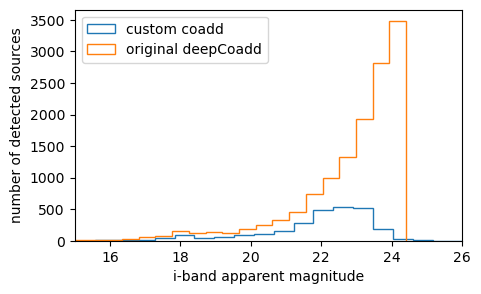

In [53]:
plt.figure(figsize=(5, 3))

plt.hist(my_sources['i_CalibMag_AB'], bins=20, histtype='step', label='custom coadd')
plt.hist(tap_table['i_calibMag'], bins=20, histtype='step', label='original deepCoadd')

plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.legend(loc='upper left')
plt.xlim([15, 26])
plt.show()

# 4. Exercises for the learner

1. Lower the source detection threshold (e.g., from 10 to 5) and rerun the source detection and analysis. Remember to change the SNR limit in the TAP query to the `Objects` table, in order to make a meaningful comparison. 
> (Recall that the `Objects` table only includes SNR>5 detections, so if the source detection threshold for the custom `deepCoadd` is lowered to below 5, a meaningful comparison with the `Objects` table will not be possible. Rerun source detection on the original `deepCoadd` if you want to explore low-SNR detections).
2. Compare not just the apparent magnitudes between the custom `deepCoadd` and original `deepCoadd`, but also shape parameters like PSF or the `SdssShape` moments.
3. Return to tutorial notebook 09a, create a custom `deepCoadd` for Window2, and compare it to the custom `deepCoadd` for Window1.